The code is cusotmosed based on the root code provided in
https://www.researchgate.net/publication/359480166_Discontinuity_Computing_using_Physics-Informed_Neural_Networks

In [9]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
import os
import matplotlib.pyplot as plt
# Seeds
torch.manual_seed(12)
np.random.seed(12)
x_min=0;
x_max=1;
t_max=0.15
nx=101;
nt=101
ct=1
er_c1=1e-3
# er_c2=1e-4
   
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N = len(x)
    rho_init = np.zeros((x.shape[0]))                                              
    u_init = np.zeros((x.shape[0]))                                                
    p_init = np.zeros((x.shape[0]))                                                

    # rho, p - initial condition
    for i in range(N):
        if (x[i] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

# Generate Neural Network adative tanh(ax) activation function
class ParamTanh(nn.Module):
    def __init__(self, alpha):
        super(ParamTanh, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha, requires_grad=True))

    def forward(self, x):
        return torch.tanh(self.alpha * x)
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()    
        tn=15                                              
        self.net.add_module('Linear_layer_1', nn.Linear(2, tn))                     
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              

        for num in range(2, 5):                                                     
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(tn, tn))       
            self.net.add_module('Tanh_layer_%d' % (num), ParamTanh(alpha=0.9))                 
        self.net.add_module('Linear_layer_final', nn.Linear(tn, 4))                 

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                
        rho,p,u,nui = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        
        gamma = 1.4                                                    

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]         

        drho_gg = gradients(rho_x, x)[0]      
        rho_tx, rho_xx = drho_gg[:, 0], drho_gg[:, 1]  


        du_g = gradients(u, x)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            

       # dp_g = gradients(p, x)[0]                                     
       # p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           
        
        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        d2U2_g = gradients(U2_x, x)[0]
        U2_tx,U2_xx = d2U2_g[:,:1], d2U2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        d2U3_g = gradients(U3_x, x)[0]
        U3_tx,U3_xx = d2U3_g[:,:1], d2U3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

        d = 0.12*(abs(u_x)-u_x)  + 1 #+0.1*(abs(rho_x)-rho_x)
        #d = 0.1*(abs(u_x))+1e-18
        # d=1;
        nu=nui**2
     
        f = (((rho_t + U2_x-nu*rho_xx)/d)**2).mean() + \
            (((U2_t  + F2_x-nu*U2_xx)/d)**2).mean() + \
            (((U3_t  + F3_x-nu*U3_xx)/d)**2).mean() +((nu)**2).mean()
           # ((rho_t).mean())**2  +\
           # ((U3_t).mean())**2 
    
        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics
    
#device = torch.device('cuda')         # change to cpu if you dont have a cuda device     
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  
# os.remove('loss.dat')                       
                                                
                                             
x = np.linspace(x_min, x_max, nx)                                   
t = np.linspace(0, t_max, nt)                                     
t_grid, x_grid = np.meshgrid(t, x)                                 
T = t_grid.flatten()[:, None]                                      
X = x_grid.flatten()[:, None]                                      
#id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)   
# we use all llocation points because PINN is free from over fitting. If you wish you can use random
x_int = X[:, 0][:, None]                                        
t_int = T[:, 0][:, None]                                        
x_int_train = np.hstack((t_int, x_int))   

x = np.linspace(x_min, x_max, nx)                                   
t = np.linspace(0, t_max, nt)                                       
t_grid, x_grid = np.meshgrid(t, x)                                 
T = t_grid.flatten()[:, None]                                      
X = x_grid.flatten()[:, None]                                      
x_ic = x_grid[:, 0][:, None]                                   
t_ic = t_grid[:, 0][:, None]                                   
x_ic_train = np.hstack((t_ic, x_ic))                               

rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)                    
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
# x_int_train1 = torch.tensor(x_int_train1, requires_grad=True, dtype=torch.float32).to(device)
rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int_train)                                    
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   
        loss = loss_pde + 1*loss_ic                                          
        loss.backward()
        return loss


In [10]:
lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# %%
epoch = 0
epochi = epoch
epochs = 1001
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
        

                                                      # Learning rate
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.1,max_iter=20)

# %%

epochi = epoch

epochs = 501
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    if loss_value<er_c1:
        # loss = optimizer.step(closure1)
        # if loss_value<er_c2:
            print('Converged')
            break
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
toc = time.time()
# torch.save(model.state_dict(), 'so_model.pth')
# print(f'Total training time: {toc - tic}')



epoch 1: loss 1.197937
epoch 2: loss 1.171996
epoch 3: loss 1.146479
epoch 4: loss 1.121322
epoch 5: loss 1.096472
epoch 6: loss 1.071912
epoch 7: loss 1.047633
epoch 8: loss 1.023627
epoch 9: loss 0.999884
epoch 10: loss 0.976390
epoch 11: loss 0.953132
epoch 12: loss 0.930094
epoch 13: loss 0.907265
epoch 14: loss 0.884633
epoch 15: loss 0.862190
epoch 16: loss 0.839933
epoch 17: loss 0.817862
epoch 18: loss 0.795983
epoch 19: loss 0.774307
epoch 20: loss 0.752848
epoch 21: loss 0.731628
epoch 22: loss 0.710671
epoch 23: loss 0.690010
epoch 24: loss 0.669682
epoch 25: loss 0.649728
epoch 26: loss 0.630195
epoch 27: loss 0.611135
epoch 28: loss 0.592603
epoch 29: loss 0.574658
epoch 30: loss 0.557361
epoch 31: loss 0.540776
epoch 32: loss 0.524966
epoch 33: loss 0.509991
epoch 34: loss 0.495911
epoch 35: loss 0.482780
epoch 36: loss 0.470647
epoch 37: loss 0.459548
epoch 38: loss 0.449511
epoch 39: loss 0.440554
epoch 40: loss 0.432676
epoch 41: loss 0.425865
epoch 42: loss 0.420092
e

In [11]:
x = np.linspace(x_min, x_max, ct*nx)                                   
t = np.linspace(t_max, t_max, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

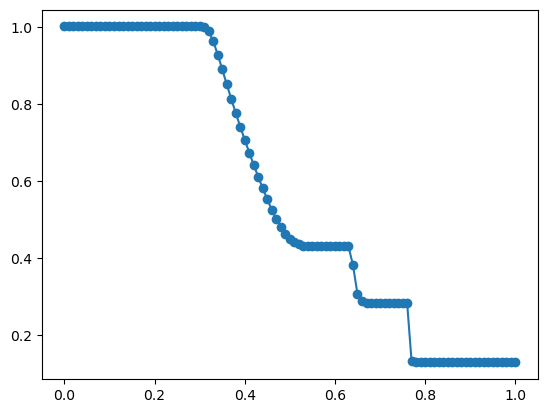

In [12]:
plt.plot(x,u_pred[:,0], marker='o', label='Circle')